In [1]:
import json
import numpy as np 
import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from Utilities import Add_ID_Count_Neighbours

import torch
import torch.nn as nn
from torch import Tensor

from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from models import GCN_k_m
from Utilities import TripletData, CustomTripletMarginLoss, prepare_triplet_fold_loader, prepare_pair_loader, score
from Utilities import extract_k_closest_embedding, extract_k_closest_homdist, compute_jaccard, compute_distance_matrix
from training import training_loop


In [3]:
homomorphism_path = 'data/homomorphism_counts/ENZYMES_44.homson'
distance = 'L2'
scaling = 'counts'
dist_matrix = compute_distance_matrix(homomorphism_path, distance, scaling, scale_y=True)


### DataLoader Option 1.
Obtain standard train-validation test split, where 70% are train, and 20-10 for validation and test set.

In [7]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', pre_transform=Add_ID_Count_Neighbours(), use_node_attr=True)
dataset = dataset.shuffle()
train_dataset = dataset[:int(0.7*len(dataset))]
val_dataset = dataset[int(0.7*len(dataset)):int(0.9*len(dataset))]
test_dataset = dataset[int(0.9*len(dataset)):]

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# Set seed and prepare dataloaders.
k = 5
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

train_loader = prepare_triplet_fold_loader(train_dataset, dist_matrix, k=k, batch_size=32, shuffle=True, device=device)
val_loader = prepare_triplet_fold_loader(val_dataset, dist_matrix, k=k, batch_size=32, shuffle=False, device=device)
test_loader = prepare_pair_loader(test_dataset, dist_matrix, batch_size=32, shuffle=False, device=device)

In [10]:
lr = 0.01
name = 'test_triplet'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=32, output_embeddings=44, n_conv_layers=3, n_linear_layers=0, name=name, dist=dist)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = CustomTripletMarginLoss(p=1).to(device)

In [11]:
# k = 5
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=50, patience=5, return_losses=True)

Epoch: 10 | Time for 10 epochs: 2m 3s
	Train Loss: 0.361
	 Val. Loss: 0.247
Early stopping triggered at epoch 11
Best epoch was 5


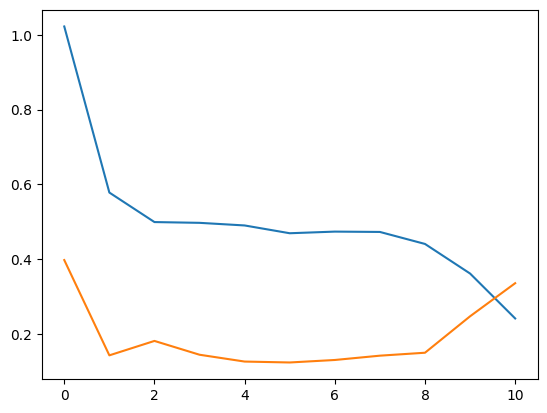

In [12]:
plt.plot(train_losses)
plt.plot(validation_losses)
plt.show()

In [13]:
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=32, output_embeddings=44, n_conv_layers=3, n_linear_layers=0, name=name, dist=dist)
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [14]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.17435699701309204


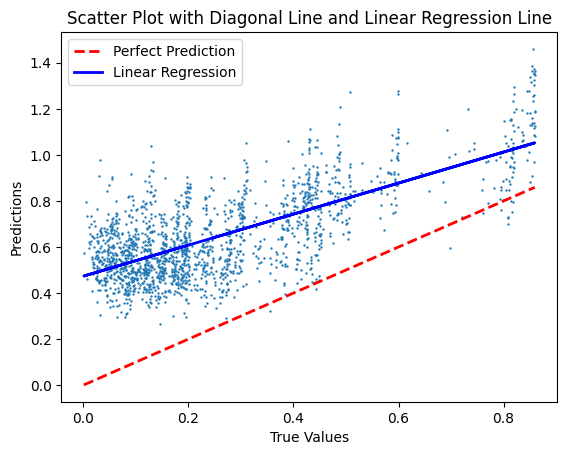

In [15]:
from sklearn.linear_model import LinearRegression

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')
# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()

Different evaluation: How well does the model map closer pairs close together.
For each graph:
- Extract k closest graphs in the original space
- Extract k closest graphs in the new space
Compare the two

In [16]:
k=10
closest_graphs_original = extract_k_closest_homdist(test_dataset, dist_matrix, k = k)
closest_graphs_embeddings = extract_k_closest_embedding(model, test_loader, k = k)

In [18]:
compute_jaccard(closest_graphs_original, closest_graphs_embeddings)

0.15174721935557842